<a href="https://colab.research.google.com/github/saigo24/Dimplomado_Ciencia_Datos/blob/main/ReconocimientoLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Loana Beltrán y Santiago Flórez. Tomado de [convolution 3d](https://www.tensorflow.org/tutorials/video/video_classification).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Reconocimiento de Lenguaje de Señas con  una Red Neuronal Convolucional 3D

Este cuaderno muestra el entrenamiento de una red neuronal convolucional (CNN) 3D para la clasificación de videos usando el conjunto de datos de reconocimiento de lenguaje de señas [LSC_Corte](https://www.dropbox.com/s/awlpe9ol34657el/LSC_Corte.zip?dl=0). En este se realiza preprocesamiento de datos de video como entrada para un modelo de red neuronal convolucional en 3D con conexiones residuales utilizando la API funcional de Keras, después se entrena el modelo y se evaluan sus resultados.


## Setup

Instalamos e importamos las bibliotecas necesarias, que incluyen: remotezip para inspeccionar el contenido de un archivo ZIP, tqdm para usar una barra de progreso, OpenCV para procesar archivos de video, einops para realizar operaciones de tensor más complejas, entre otras.

In [ ]:
!pip install remotezip tqdm opencv-python einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7933 sha256=95443b26a0be6d372f7f0e1af9fb1755d952990c5727fbbad6982dc5f17fa631
  Stored in directory: /root/.cache/pip/wheels/fc/76/04/beed1a6df4eb7430ee13c3900746edd517e5e597298d1f73f3
Successfully built remotezip


In [ ]:
#pip uninstall tensorflow
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


In [ ]:
print(tf.__version__)

2.11.0


## Preprocesamiento de datos

La celda oculta a continuación define las funciones auxiliares para descargar un segmento de datos del conjunto de datos LSC_Corte y cargarlo en un `tf.data.Dataset`.

La clase `FrameGenerator` al final del bloque oculto es la utilidad más importante aquí. Crea un objeto iterable que puede introducir datos en la canalización de datos de TensorFlow. Específicamente, esta clase contiene un generador de Python que carga los cuadros de video junto con su etiqueta codificada. La función generadora (`__call__`) produce la matriz de fotogramas producida por `frames_from_video_file` y un vector codificado one-hot de la etiqueta asociada con el conjunto de fotogramas.

In [ ]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
URL = 'https://www.dropbox.com/s/awlpe9ol34657el/LSC_Corte.zip?dl=1'
download_dir = pathlib.Path('./LSC_Corte_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 4,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 120/120 [03:02<00:00,  1.52s/it]


val :


100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


test :


100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


Crear los conjuntos de entrenamiento, validación y prueba (`train_ds`, `val_ds`, and `test_ds`).

In [ ]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [ ]:
subset_paths

{'train': PosixPath('LSC_Corte_subset/train'),
 'val': PosixPath('LSC_Corte_subset/val'),
 'test': PosixPath('LSC_Corte_subset/test')}

## Creación del modelo
El siguiente modelo de red neuronal convolucional 3D se basa en el artículo [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) de D. Tran et al. (2017). El documento compara varias versiones de 3D ResNets. En lugar de operar en una sola imagen con dimensiones `(alto, ancho)`, como ResNet estándar, estos operan en el volumen de video `(tiempo, alto, ancho)`. El enfoque más obvio para este problema sería reemplazar cada convolución 2D (`layers.Conv2D`) con una convolución 3D (`layers.Conv3D`).

Este tutorial usa una convolución D (2 + 1) con [conexiones residuales] (https://arxiv.org/abs/1512.03385). La convolución (2 + 1)D permite la descomposición de las dimensiones espacial y temporal, creando así dos pasos separados. Una ventaja de este enfoque es que la factorización de las circunvoluciones en dimensiones espaciales y temporales ahorra parámetros.

Para cada ubicación de salida, una convolución 3D combina todos los vectores de un parche 3D del volumen para crear un vector en el volumen de salida.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

Esta operación toma entradas de `tiempo * alto * ancho * canales` y produce salidas de `canales` (asumiendo que el número de canales de entrada y salida es el mismo. Entonces, una capa de convolución 3D con un tamaño de kernel de `(3 x 3 x 3 )" necesitaría una matriz de peso con "27 * canales ** 2" entradas. El documento de referencia encontró que un enfoque más efectivo y eficiente era factorizar la convolución. En lugar de una única convolución 3D para procesar las dimensiones de tiempo y espacio, propusieron una convolución \"(2+1)D\" que procesa las dimensiones de espacio y tiempo por separado. La siguiente figura muestra las convoluciones espaciales y temporales factorizadas de una convolución (2 + 1)D.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

La principal ventaja de este enfoque es que reduce el número de parámetros. En la convolución (2 + 1)D, la convolución espacial toma datos de la forma `(1, ancho, alto)`, mientras que la convolución temporal toma datos de la forma `(tiempo, 1, 1)`. Por ejemplo, una convolución D (2 + 1) con un tamaño de núcleo `(3 x 3 x 3)` necesitaría matrices de peso de tamaño `(9 * canales**2) + (3 * canales**2)`, menos de la mitad de la convolución 3D completa. Este tutorial implementa (2 + 1)D ResNet18, donde cada convolución en la resnet se reemplaza por una convolución (2+1)D.

In [ ]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

Un modelo ResNet modelo resnet se hace a partir de una secuencia de bloques residuales.
Un bloque residual tiene dos ramas. La rama principal realiza el cálculo, pero es difícil que fluyan los gradientes.
La rama residual pasa por alto el cálculo principal y, en su mayoría, solo agrega la entrada a la salida de la rama principal.
Los gradientes fluyen fácilmente a través de esta rama.
Por lo tanto, estará presente un camino fácil desde la función de pérdida a cualquiera de las ramas principales del bloque residual.
Esto evita el problema del gradiente de fuga.

Cree la rama principal del bloque residual con la siguiente clase. A diferencia de la estructura estándar de ResNet, esta utiliza la capa `Conv2Plus1D` personalizada en lugar de `layers.Conv2D`

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Para agregar la rama residual a la rama principal, debe tener el mismo tamaño. La capa 'Proyecto' a continuación se ocupa de los casos en los que se cambia el número de canales en la sucursal. En particular, se agrega una secuencia de capa densamente conectada seguida de normalización.

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` para introducir una conexión de salto entre las capas del modelo.

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Es necesario cambiar el tamaño del video para reducir la resolución de los datos. En particular, la reducción de la resolución de los cuadros de video permite que el modelo examine partes específicas de los cuadros para detectar patrones que pueden ser específicos de una determinada acción. A través de la reducción de muestreo, se puede descartar información no esencial. Además, cambiar el tamaño del video permitirá la reducción de la dimensionalidad y, por lo tanto, un procesamiento más rápido a través del modelo.

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [ ]:
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

Utilice la [API funcional de Keras](https://www.tensorflow.org/guide/keras/funcional) para construir la red residual.

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [ ]:
model.summary()

model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv2_plus1d_2 (Conv2Plus1D)   (None, 10, 224, 224  3152        ['input_4[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 10, 224, 224  64         ['conv2_plus1d_2[0][0]']         
 rmalization)                   , 16)                                                         

In [ ]:
input_shape = (8, 10, 224, 224, 3)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv3D( 16, (3,7,7), input_shape=input_shape[2:])(x)
print(y.shape)


(8, 8, 218, 218, 16)


In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

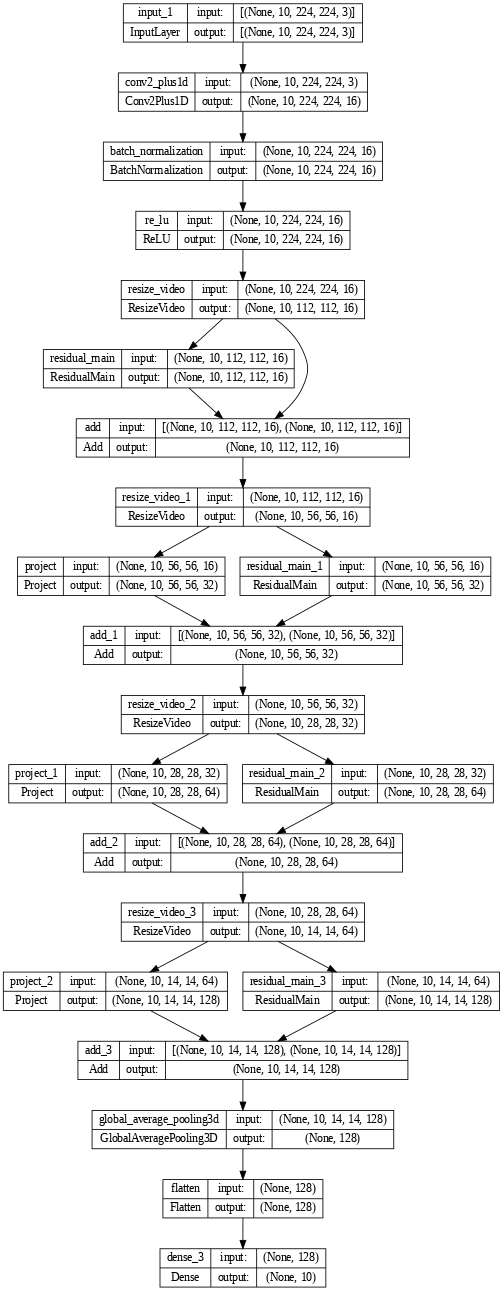

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Entrenamiento del modelo

Se elige el optimizador `tf.keras.optimizers.Adam` y la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy`. Se utiliza el argumento `metrics` para ver la precisión del rendimiento del modelo en cada paso.

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

Entrena el modelo durante 50 épocas con el método `Model.fit` de Keras.

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x = train_ds,
                    epochs = 50,
                    validation_data = val_ds,
                    verbose=1)


Epoch 1/50
15/15 [==============================] - 96s 6s/step - loss: 1.2622 - accuracy: 0.4750 - val_loss: 1.2276 - val_accuracy: 0.4750
Epoch 2/50
15/15 [==============================] - 78s 5s/step - loss: 1.2094 - accuracy: 0.4833 - val_loss: 1.2511 - val_accuracy: 0.3750
Epoch 3/50
15/15 [==============================] - 81s 5s/step - loss: 1.2127 - accuracy: 0.5250 - val_loss: 1.2099 - val_accuracy: 0.5500
Epoch 4/50
15/15 [==============================] - 79s 5s/step - loss: 1.2713 - accuracy: 0.4500 - val_loss: 1.2370 - val_accuracy: 0.5750
Epoch 5/50
15/15 [==============================] - 80s 5s/step - loss: 1.1872 - accuracy: 0.4750 - val_loss: 1.1397 - val_accuracy: 0.6000
Epoch 6/50
15/15 [==============================] - 82s 5s/step - loss: 1.0957 - accuracy: 0.5833 - val_loss: 1.1435 - val_accuracy: 0.5000
Epoch 7/50
15/15 [==============================] - 79s 5s/step - loss: 1.0855 - accuracy: 0.6083 - val_loss: 1.1997 - val_accuracy: 0.4750
Epoch 8/50
15/15 [==

### Visualización de resultados

Se crean gráficos de pérdida y precisión en los conjuntos de entrenamiento y validación:

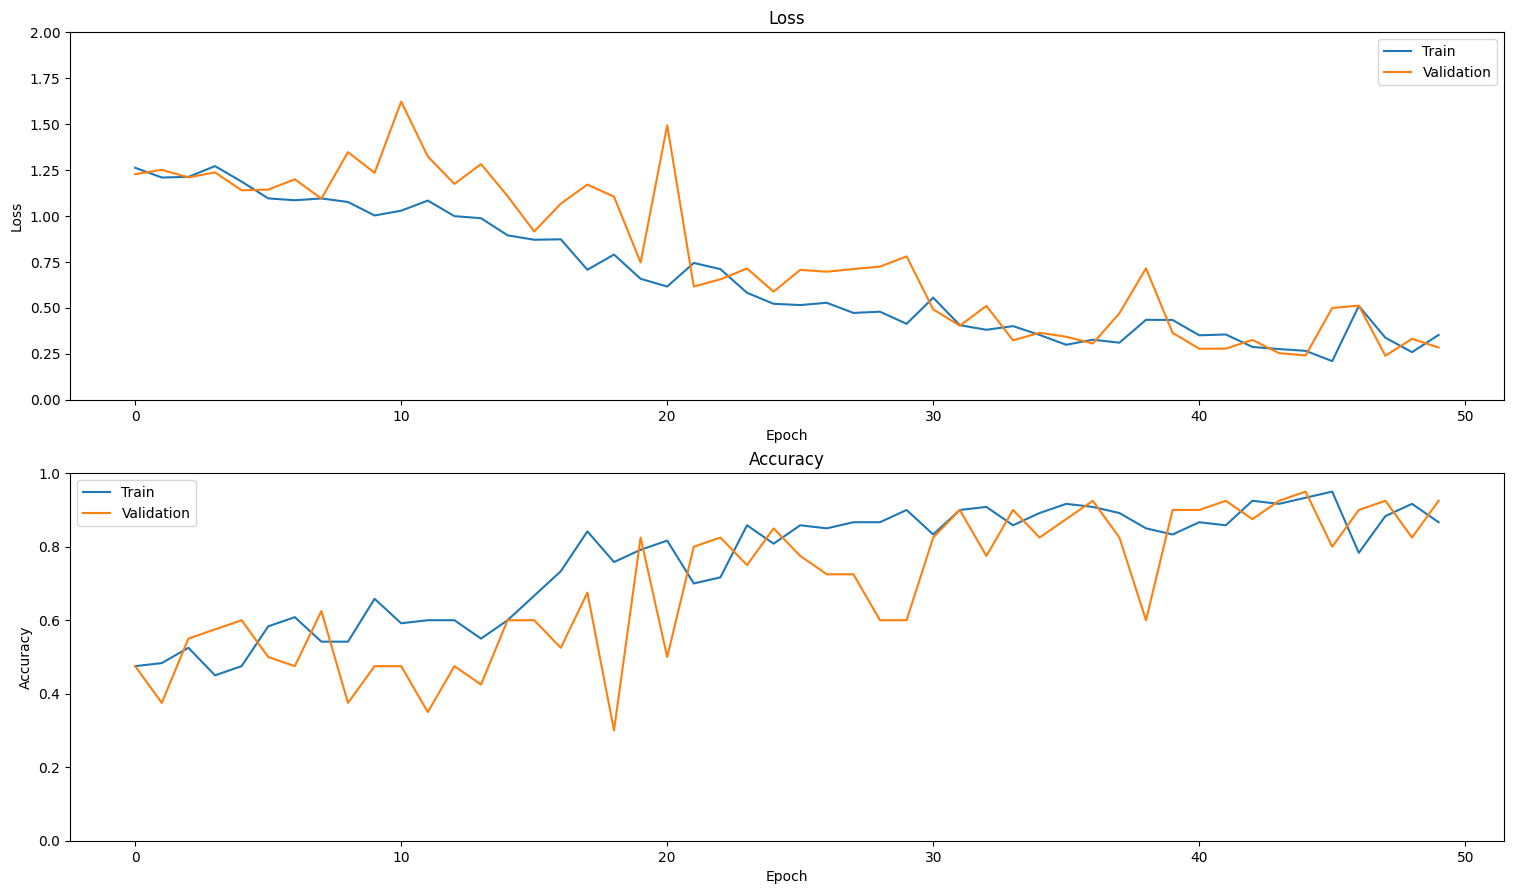

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluación del modelo

Se usa `Model.evaluate` de Keras para obtener la pérdida y la precisión en el conjunto de datos de prueba.

Nota: El modelo en este caso usa un subconjunto del conjunto de datos LSC_Corte para mantener un tiempo de entrenamiento razonable. La precisión y la pérdida se pueden mejorar con más ajustes de hiperparámetros o más datos de entrenamiento.

In [ ]:
model.evaluate(test_ds, return_dict=True)

5/5 [==============================] - 18s 3s/step - loss: 0.6141 - accuracy: 0.9000


{'loss': 0.6141397356987, 'accuracy': 0.8999999761581421}

Para visualizar más el rendimiento del modelo, se usa una [matriz de confusión](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). La matriz de confusión le permite evaluar el rendimiento del modelo de clasificación más allá de la precisión. Para construir la matriz de confusión para este problema de clasificación de clases múltiples, se obtienen los valores reales en el conjunto de prueba y los valores pronosticados.

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())
print(labels)

['BuenasNoches', 'BuenasTardes', 'BuenosDias', 'Gracias']


15/15 [==============================] - 54s 4s/step


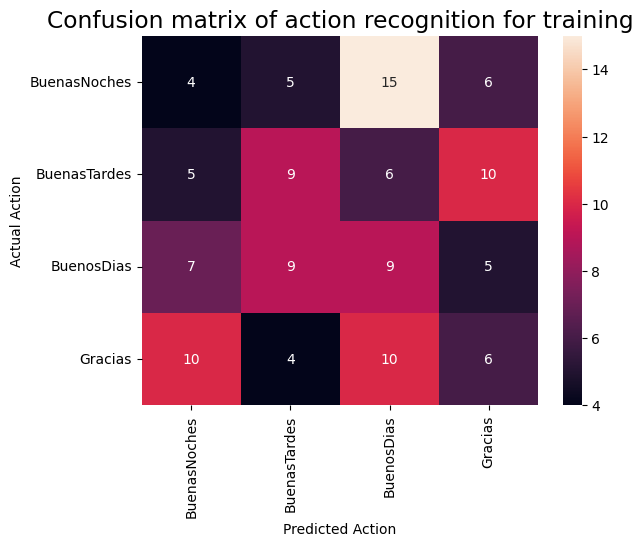

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

5/5 [==============================] - 18s 4s/step


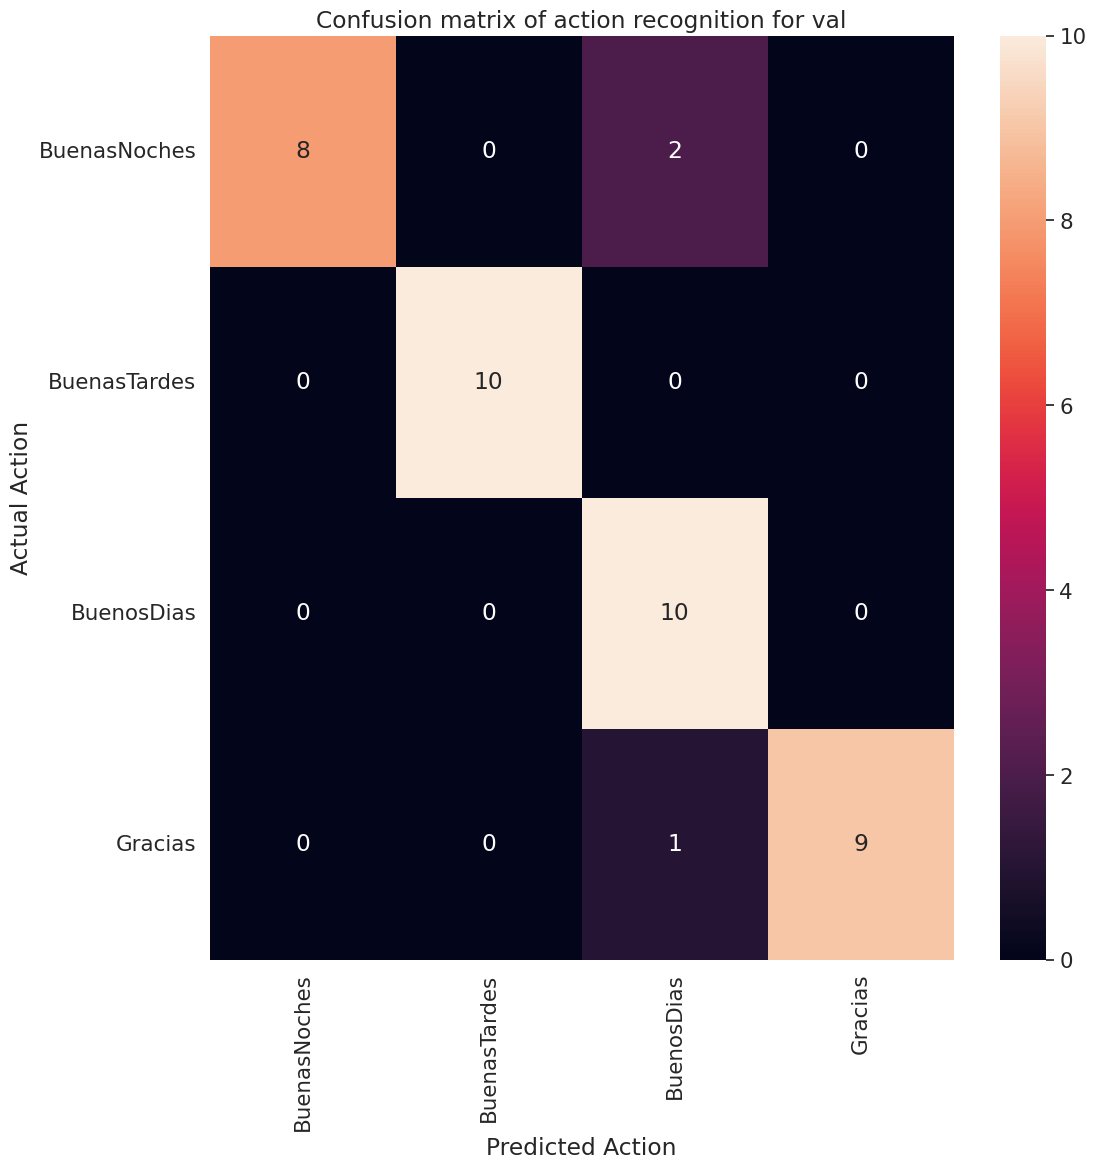

In [ ]:
actual, predicted = get_actual_predicted_labels(val_ds)
plot_confusion_matrix(actual, predicted, labels, 'val')

5/5 [==============================] - 17s 4s/step


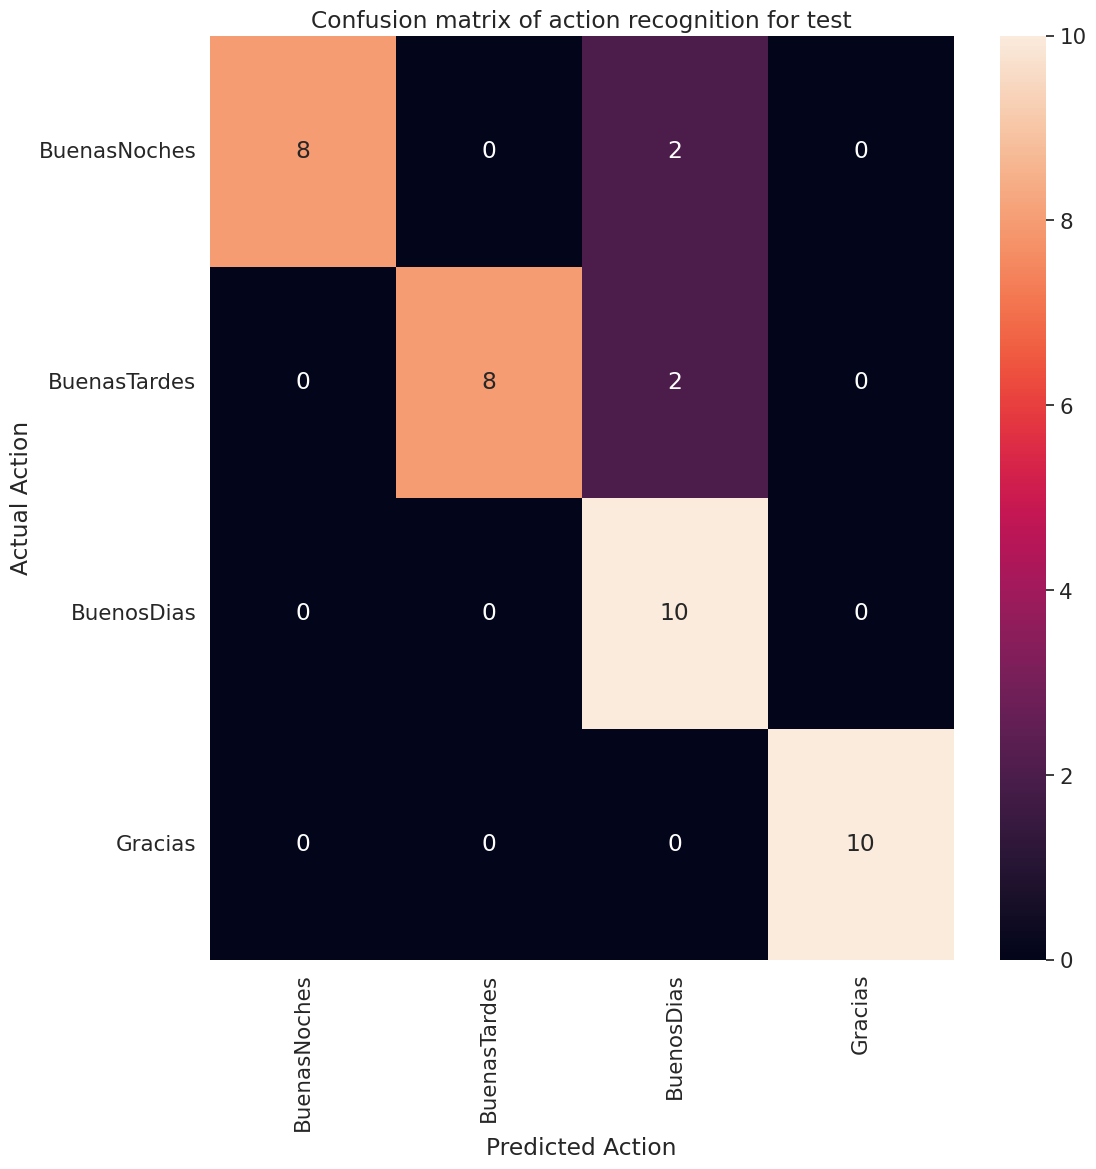

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

Los valores de precisión y recuperación para cada clase también se pueden calcular utilizando una matriz de confusión.

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

{'BuenasNoches': 1.0,
 'BuenasTardes': 1.0,
 'BuenosDias': 0.7692307692307693,
 'Gracias': 1.0}

In [ ]:
recall

{'BuenasNoches': 0.8, 'BuenasTardes': 1.0, 'BuenosDias': 1.0, 'Gracias': 0.9}